## Methodology

### 1. Data Processing

#### 1.1 Course Data  
We began by collecting a dataset of courses for the Fall 2024 term. Each course entry included attributes such as:

- **courseId** (e.g., “PSTAT   134”),  
- **title** (e.g., “STAT DATA SCIENCE”),  
- **description** ("Applications of advanced data science tools for data retrieval, statistical analysis and machine learning, optimization, and visualization. Multiple c ase studies will illustrate the practical use of these tools."),  
- and other relevant metadata.

To prepare these for modeling, we **merged** the course title and description into a single text field. We further **enriched** this field by mapping the course prefix (e.g., “CMPSC”, “MATH”) to its full department name (e.g., “computer science”, “mathematics”) and appending that to the text. This final merged text was then **cleaned** by:

1. Converting to lowercase,  
2. Removing non-alphanumeric characters, and  
3. Filtering out a small set of “unwanted words” (e.g., “group”, “club”, etc.).

We then tokenized each cleaned text into words (i.e., unigrams) for indexing.  

In [30]:
import pandas as pd
from rank_bm25 import BM25Okapi
import re
# mapping course prefix -> full dept name
dept_dict = {
    "ANTH": "anthropology",
    "ART": "art",
    "ARTHI": "art history",
    "AS AM": "asian american study",
    "BIOE": "biological engineering",
    "BL ST": "black studies",
    "CH E": "chemical engineering",
    "CHEM": "chemistry",
    "CH ST": "chicana and chicano studies",
    "CHIN": "chinese",
    "CLASS": "classics",
    "COMM": "communication",
    "C LIT": "comparative literature",
    "CMPSC": "computer science",
    "CNCSP": "counseling clinical school psychology",
    "DANCE": "dance",
    "DYNS": "dynamical neuroscience",
    "EARTH": "earth science",
    "EACS": "east asian languages cultural studies",
    "EEMB": "ecology evolution and marine biology",
    "ECON": "economics",
    "ED": "education",
    "ECE": "electrical computer engineering",
    "ENGR": "engineering",
    "ENGL": "english",
    "ESM": "environmental science and management",
    "ENV S": "environmental studies",
    "ESS": "exercise and sport studies",
    "FEMST": "feminist",
    "FAMST": "film and media studies",
    "FR": "french",
    "GEOG": "geography",
    "GER": "german",
    "GLOBL": "global studies",
    "GREEK": "greek",
    "HEB": "hebrew",
    "HIST": "history",
    "IQB": "quantitative biosciences",
    "INT": "interdisciplinary",
    "ITAL": "italian",
    "JAPAN": "japanese",
    "KOR": "korean",
    "LATIN": "latin",
    "LAIS": "latin american and iberian studies",
    "LING": "linguistics",
    "MARSC": "marine science",
    "MATRL": "materials",
    "MATH": "mathematics",
    "ME": "mechanical engineering",
    "MAT": "media arts and technology",
    "ME ST": "mechanical engineering",
    "MS": "army physical training",
    "MCDB": "molecular cellular and developmental biology",
    "MUS": "music",
    "MUS A": "music performance audition",
    "PHIL": "philosophy",
    "PHYS": "physics",
    "PORT": "portuguese",
    "PSY": "psychology",
    "RENST": "renewable and sustainable technology",
    "RUSS": "russian",
    "SLAV": "german and slavic studies",
    "SOC": "sociology",
    "SPAN": "spanish",
    "PSTAT": "statistics applied probability data science",
    "THTR": "theater and dance",
    "WRIT": "writing",
}

def parse_dept(course_id: str) -> str:
    """Map course prefix to a full department name."""
    if not isinstance(course_id, str):
        return ""
    cid = course_id.strip().upper()
    # Try longest matches first
    sorted_keys = sorted(dept_dict.keys(), key=len, reverse=True)
    for k in sorted_keys:
        if cid.startswith(k.upper()):
            return dept_dict[k]
    return ""

def remove_unwanted_words(text: str) -> str:
    """
    Cleans text by:
    - lowercasing
    - removing punctuation except spaces
    - removing certain unwanted words
    """
    UNWANTED_WORDS = {"group", "club", "team", "organization"}
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]+', '', text)
    tokens = text.split()
    filtered_tokens = [t for t in tokens if t not in UNWANTED_WORDS]
    return " ".join(filtered_tokens)

# Read in courses CSV
df_courses = pd.read_csv("./Fall2024_Courses.csv")

# Create a 'merged_text' that includes title + description
df_courses["merged_text"] = (
    df_courses["title"].fillna("").astype(str) + " " +
    df_courses["description"].fillna("").astype(str)
)

# Add department name to the merged text
df_courses["dept_fullname"] = df_courses["courseId"].apply(parse_dept)
df_courses["merged_text"] = (
    df_courses["merged_text"] + " " + df_courses["dept_fullname"].fillna("")
)

# Clean the final merged_text
df_courses["merged_text_clean"] = df_courses["merged_text"].apply(remove_unwanted_words)

tokenized_courses = [doc.split() for doc in df_courses["merged_text_clean"]]

bm25 = BM25Okapi(tokenized_courses)

def parse_last_three_digits(course_id: str) -> int:
    """
    Returns the integer value of the last 1–3 digits of courseId.
    If no digits are found, returns 9999 (meaning 'no match').
    """
    pattern = r'(\d{1,3})$'  # captures up to 3 digits at the end
    match = re.search(pattern, course_id)
    if match:
        return int(match.group(1))
    return 9999

#### 1.2 Student Data  
The student dataset contained fields such as:

- **AcademicInterest** (e.g., “artificial intelligence, data science”),  
- **Major** (e.g., “Computer Science”),  
- **ResearchInterests** (e.g., “machine learning, big data”),  
- **YearOfStudy** (“freshman”, “sophomore”, “junior”, or “senior”),  
- **ExtracurricularActivities**, **Skills**, **ClubMemberships**, **Languages**, etc.

We **cleaned** these fields similarly (lowercasing, removing punctuation, excluding “unwanted words”) and **split** them into tokens. To facilitate **fine-grained weighting**, we kept the major fields separate:

- **tokens_academic_interest**  
- **tokens_major**  
- **tokens_research_interest**

We **merged** other unweighted fields (ExtracurricularActivities, Skills, ClubMemberships, Languages) into a single “unweighted” token list. Additionally, we **extracted** the student’s year of study into a normalized form (e.g., “freshman”, “senior”) for later use in difficulty-level matching.

In [31]:
import pandas as pd
import re

# Assuming df_students is already loaded, e.g.:
df_students = pd.read_csv("./student_data_extended.csv")

# 1) Define a simple text-cleaning helper (inline for convenience)
def remove_unwanted_words(text: str) -> str:
    """
    Cleans text by:
    - lowercasing
    - removing punctuation except spaces
    - removing specific unwanted words (example set below)
    """
    UNWANTED_WORDS = {"group", "club", "team", "organization"}
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # remove non-alphanumeric characters except spaces
    text = re.sub(r'[^a-z0-9\s]+', '', text)
    # split into tokens
    tokens = text.split()
    # remove certain unwanted words
    filtered_tokens = [t for t in tokens if t not in UNWANTED_WORDS]
    return " ".join(filtered_tokens)

# 2) Create new columns for weighted fields:
df_students['tokens_academic_interest'] = ""
df_students['tokens_major'] = ""
df_students['tokens_research_interest'] = ""

# 3) Create new column for unweighted fields:
df_students['tokens_unweighted'] = ""

# 4) Create new column for year_of_study (cleaned):
df_students['year_of_study_cleaned'] = ""


# 5) Iterate through rows and process each
for i, row in df_students.iterrows():
    # --- Weighted fields ---
    academic_text  = remove_unwanted_words(str(row.get('AcademicInterest', '')))
    major_text     = remove_unwanted_words(str(row.get('Major', '')))
    research_text  = remove_unwanted_words(str(row.get('ResearchInterests', '')))

    # Assign tokens back to the DataFrame
    df_students.at[i, 'tokens_academic_interest'] = academic_text.split()
    df_students.at[i, 'tokens_major']            = major_text.split()
    df_students.at[i, 'tokens_research_interest'] = research_text.split()

    # --- Unweighted fields ---
    extra_text  = remove_unwanted_words(str(row.get('ExtracurricularActivities', '')))
    skills_text = remove_unwanted_words(str(row.get('Skills', '')))
    clubs_text  = remove_unwanted_words(str(row.get('ClubMemberships', '')))
    langs_text  = remove_unwanted_words(str(row.get('Languages', '')))

    # Merge these unweighted fields into one string
    combined_unweighted = (
        extra_text + " "
        + skills_text + " "
        + clubs_text + " "
        + langs_text
    ).strip()

    df_students.at[i, 'tokens_unweighted'] = combined_unweighted.split()

    # --- Clean YearOfStudy ---
    year_of_study = str(row.get('YearOfStudy', '')).strip().lower()
    df_students.at[i, 'year_of_study_cleaned'] = year_of_study

# 6) Now df_students has these new columns in place.
print(df_students.head())


   StudentID       Name  AcademicInterest ExtracurricularActivities  \
0          1  Student 1        Psychology               Debate Club   
1          2  Student 2        Psychology               Debate Club   
2          3  Student 3           History           Volunteer Group   
3          4  Student 4  Computer Science           Volunteer Group   
4          5  Student 5  Computer Science               Sports Team   

                                              Skills  Location YearOfStudy  \
0                                    Problem Solving  New York    Freshman   
1  Leadership, Problem Solving, Public Speaking, ...    Boston    Graduate   
2  Data Analysis, Leadership, Public Speaking, Ar...   Chicago      Junior   
3    Public Speaking, Data Analysis, Problem Solving   Chicago    Graduate   
4                                      Data Analysis   Chicago    Graduate   

              Major   GPA                                    Languages  \
0        Psychology  3.27   Ch

# Data Matching using embeddings from openai
### 2. Choice of Model

We experimented with multiple text-based similarity approaches (including **cosine similarity** and **Jaccard** measures) to match courses to students. However, we observed that the **BM25** (Okapi BM25) model provided:

1. **Better handling of term frequency** than simple TF-IDF,  
2. **Strong performance** in retrieving the most relevant documents given a query, and  
3. **Document length normalization**: Courses vary in description length, and BM25’s built-in normalization gave more consistent results than basic TF-IDF.  
4. **Robustness to varying text lengths** BM25 is a standard in information retrieval, particularly for matching short queries (student interests) to richer documents (course descriptions).

As a result, we **adopted BM25** as our primary model for ranking courses based on how well they match each student’s interests and background.

### 3. Model Implementation & Fine-Tuning

In **recomender--bm25.ipynb**, we implement the following steps:

#### 3.1 BM25 Index  
First, we built a **BM25 index** over all tokenized course texts. This index allows us to quickly compute a relevance score between any given “query” and each course document. In our context, **each student** generates a query based on their tokenized fields.

#### 3.2 Weighted Multi-Field Queries  
   For each student, we run **multiple** BM25 queries—one per field—to capture different aspects of the profile:

- **AcademicInterest** → weight $W_{\mathrm{Academic}} = 2.0$
- **Major** → weight $W_{\mathrm{Major}} = 3.0$
- **ResearchInterests** → weight $W_{\mathrm{Research}} = 2.0$
- **Unweighted fields** (ExtracurricularActivities, Skills, etc.) → weight $W_{\mathrm{Unweighted}} = 1.0$



We computed BM25 scores **separately** for each field’s tokens, then took a **weighted sum** of those scores to produce a single relevance score per course. This ensures that, for example, a student’s Major can outweigh their extracurricular activities when recommending advanced courses.

#### 3.3 Bigrams for Research Tokens  
To better capture multi-word phrases (e.g., “machine learning”, “data science”) in the **ResearchInterests** field, we **generated bigrams** by concatenating adjacent tokens (e.g., “machine_learning”). These bigrams were appended to the original unigrams, allowing BM25 to match either single words or two-word expressions in the research domain.

#### 3.4 Matching Course Difficulty to Year of Study  
To align students with appropriately leveled courses, we **parsed the last 1–3 digits** of each course ID (e.g., `CMPSC16` → `16`, `MATH101` → `101`) to estimate course difficulty:

- **Lower-division courses** were identified if the numeric part of courseID was < 100,  
- **Mid-level courses** if it was between 100 and 200.

We then **boosted** the BM25 scores accordingly:

- **Freshman/Sophomore** → boosted courses with < 100 in their ID,  
- **Junior/Senior** → boosted courses in the 100–199 range.

This post-processing step slightly **raises** the scores of courses likely suited to a given academic level.

#### 3.5 Storing Recommendations:  
After computing the final BM25-based scores for each student, we extract the **top 5**  course recommendations and store them in a **separate CSV file**. Each row contains the student’s identifier, year of study, the course ID and title, and the final BM25 score. This approach centralizes all recommendations in a single dataset, allowing for simpler **post-analysis**, checks, and future integrations.

In [32]:
import numpy as np
from rank_bm25 import BM25Okapi
import re

def parse_last_three_digits(course_id: str) -> int:
    """Extract integer from the last 1–3 digits of course_id. To recommend course based on year of study"""
    pattern = r'(\d{1,3})$'
    match = re.search(pattern, course_id)
    if match:
        return int(match.group(1))
    return 9999

def create_bigrams(tokens):
    """
    Given a list of tokens like ["machine","learning","approach"],
    returns a list of bigrams like ["machine_learning","learning_approach"].
    """
    return [f"{tokens[i]}_{tokens[i+1]}" for i in range(len(tokens) - 1)]

# Set weighting parameters
W_ACADEMIC_INTEREST = 2.0
W_MAJOR             = 3.0
W_RESEARCH_INTEREST = 2.0
W_UNWEIGHTED        = 1.0  # For the merged, unweighted fields (e.g., extracurriculars, skills, clubs)

# Year-of-study 
BOOST_LOWER_DIVISION = 3.0 # e.g. for freshman/sophomore, < 100 courseID
BOOST_MID_LEVEL      = 2.0  # e.g. for junior/senior, [100..200) courseID
result_b = 1.8
NUM_RECS = 5  # how many recommended courses to show per student

recommendations_data = []  
# For each student, compute combined BM25 scores from their tokenized fields
# Assumes:
bm25 = BM25Okapi(tokenized_courses)
top_scores = []
for i, student_row in df_students.iterrows():
    # Extract each token list from df_students
    academic_tokens  = student_row['tokens_academic_interest']
    major_tokens     = student_row['tokens_major']
    # Bigrams for research tokens
    research_unigrams = student_row.get('tokens_research_interest', [])
    research_bigrams  = create_bigrams(research_unigrams)
    # Combine unigrams + bigrams
    research_tokens   = research_unigrams + research_bigrams
    unweighted_tokens = student_row['tokens_unweighted']

    # Get BM25 scores for each token list
    if academic_tokens:
        scores_academic = bm25.get_scores(academic_tokens)
    else:
        scores_academic = np.zeros(len(df_courses))

    if major_tokens:
        scores_major = bm25.get_scores(major_tokens)
    else:
        scores_major = np.zeros(len(df_courses))

    if research_tokens:
        scores_research = bm25.get_scores(research_tokens)
    else:
        scores_research = np.zeros(len(df_courses))

    if unweighted_tokens:
        scores_unweighted = bm25.get_scores(unweighted_tokens)
    else:
        scores_unweighted = np.zeros(len(df_courses))

    #Combine the scores with weights
    combined_scores = (
          W_ACADEMIC_INTEREST  * scores_academic
        + W_MAJOR              * scores_major
        + W_RESEARCH_INTEREST  * scores_research
        + W_UNWEIGHTED         * scores_unweighted
    )

    # apply year-of-study boosts
    year_of_study = student_row['year_of_study_cleaned']  # e.g., "freshman", "junior", etc.
    sims = list(combined_scores * result_b)  # convert to list for easy iteration

    if year_of_study in ['freshman', 'sophomore']:
        # Boost lower-division courses
        for idx in range(len(sims)):
            course_id = df_courses.loc[idx, 'courseId']
            if parse_last_three_digits(course_id) < 100:
                sims[idx] *= BOOST_LOWER_DIVISION
    elif year_of_study in ['junior', 'senior']:
        # Boost mid-level courses
        for idx in range(len(sims)):
            course_id = df_courses.loc[idx, 'courseId']
            last_three = parse_last_three_digits(course_id)
            if 100 <= last_three < 200:
                sims[idx] *= BOOST_MID_LEVEL

    # Final ranking & output
    sims_array = np.array(sims)
    top_indices = sims_array.argsort()[::-1][:NUM_RECS]
    for idx in top_indices:
        top_scores.append(sims_array[idx])

    row_dict = {
        'StudentIndex': i,
        'Name': student_row.get('Name', 'N/A'),
        'YearOfStudy': student_row.get('YearOfStudy', 'N/A')
    }

    # For each of the top 5 courses, add columns in the same row
    for rank, course_idx in enumerate(top_indices, start=1):
        cid    = df_courses.loc[course_idx, 'courseId']
        ctitle = df_courses.loc[course_idx, 'title']
        score  = sims_array[course_idx]

        # e.g. CourseID1, CourseID2..., CourseTitle1..., BM25Score1...
        row_dict[f'CourseID{rank}']     = cid
        row_dict[f'CourseTitle{rank}']  = ctitle
        row_dict[f'BM25Score{rank}']    = round(score, 4)

    # Append row for this student
    recommendations_data.append(row_dict)

# --- 7) Convert to DataFrame and save to CSV ---
df_recommendations = pd.DataFrame(recommendations_data)
df_recommendations.to_csv("./recommendations.csv", index=False)
print("Recommendations saved to 'recommendations.csv' with all top-5 courses on the same row.")

Recommendations saved to 'recommendations.csv' with all top-5 courses on the same row.


## Results

### 1. Histogram Analysis of Top-5 BM25 Scores

We collected the **top 5 BM25 scores** for each student and plotted a **density histogram** (see figure below)

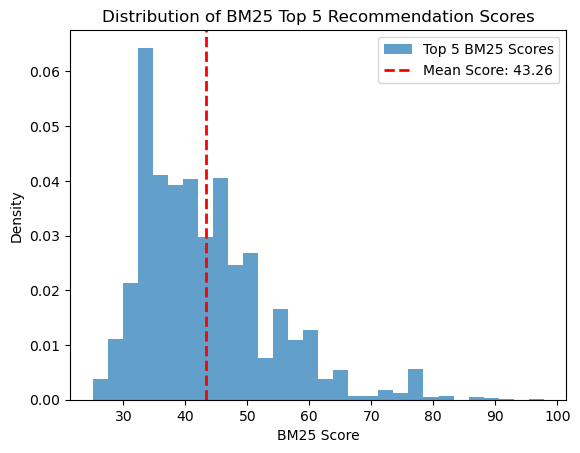

In [33]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(top_scores, bins=30, density=True, alpha=0.7, label='Top 5 BM25 Scores')

# Compute and plot mean
mean_score = np.mean(top_scores)
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, label=f'Mean Score: {mean_score:.2f}')

# Labels and legend
plt.xlabel("BM25 Score")
plt.ylabel("Density")
plt.title("Distribution of BM25 Top 5 Recommendation Scores")
plt.legend()
plt.show()



The bar heights (y-axis) represent the **density** of scores, effectively showing how common a particular range of BM25 scores is among the top 5 recommendations. The dashed vertical line marks the **mean BM25 score** for all top-5 recommendations across all students. Values to the left are below-average matches, and those to the right are stronger-than-average matches. 

Most scores fall between **30** and **50**, with the **mean** at around **43.26** (indicated by the red dashed line). This suggests that, for most students, the top recommendations fall within a moderately high range of BM25 relevance. A smaller tail extends above **50**, and only a few courses have very high BM25 scores (70+). 

In general, the distribution shows:
- A **peak** around the mid-30s, meaning many top-5 courses cluster in that region.  
- A **gradual decline** in frequency beyond 50, suggesting fewer courses achieve exceptionally high relevance.

### 2. Random Student Example
To further illustrate our recommendation outcomes, we set a **random seed** (for reproducibility) and picked a random student from the dataset.


In [34]:
# random seed for reproducibility
np.random.seed(369)

#Pick a random student
random_idx = np.random.randint(len(df_students))
student_row = df_students.iloc[random_idx]



Above is an example random student selection using a random seed of 369, which yielded student index 959 (named Student 960). We then apply our BM25-based recommendation pipeline (including field weighting and year-of-study boosting) to produce their top 5 courses:


In [35]:

print(f"=== Random Student Example (Index: {random_idx}) ===")
print(f"Name:        {student_row.get('Name', 'N/A')}")
print(f"Academic Interest:  {student_row.get('AcademicInterest', 'N/A')}")
print(f"Major:             {student_row.get('Major', 'N/A')}")
print(f"Research Interest: {student_row.get('ResearchInterests', 'N/A')}")
# Extract token lists
academic_tokens  = student_row['tokens_academic_interest']
major_tokens     = student_row['tokens_major']

research_unigrams = student_row.get('tokens_research_interest', [])
research_bigrams  = create_bigrams(research_unigrams)
research_tokens   = research_unigrams + research_bigrams

unweighted_tokens = student_row['tokens_unweighted']

if academic_tokens:
    scores_academic = bm25.get_scores(academic_tokens)
else:
    scores_academic = np.zeros(len(df_courses))

if major_tokens:
    scores_major = bm25.get_scores(major_tokens)
else:
    scores_major = np.zeros(len(df_courses))

if research_tokens:
    scores_research = bm25.get_scores(research_tokens)
else:
    scores_research = np.zeros(len(df_courses))

if unweighted_tokens:
    scores_unweighted = bm25.get_scores(unweighted_tokens)
else:
    scores_unweighted = np.zeros(len(df_courses))

combined_scores = (
      W_ACADEMIC_INTEREST  * scores_academic
    + W_MAJOR              * scores_major
    + W_RESEARCH_INTEREST  * scores_research
    + W_UNWEIGHTED         * scores_unweighted
) 

year_of_study = student_row.get('year_of_study_cleaned', '').lower()
sims = list(combined_scores * result_b) 

if year_of_study in ['freshman', 'sophomore']:
    for idx in range(len(sims)):
        if parse_last_three_digits(df_courses.loc[idx, 'courseId']) < 100:
            sims[idx] *= BOOST_LOWER_DIVISION
elif year_of_study in ['junior', 'senior']:
    for idx in range(len(sims)):
        x = parse_last_three_digits(df_courses.loc[idx, 'courseId'])
        if 100 <= x < 200:
            sims[idx] *= BOOST_MID_LEVEL

# Sort & get top 5 for this random student
sims_array = np.array(sims)
top_indices = sims_array.argsort()[::-1][:5]

print("\nTop 5 Recommended Courses:")
for rank, idx in enumerate(top_indices, start=1):
    cid = df_courses.loc[idx, 'courseId']
    ctitle = df_courses.loc[idx, 'title']
    score = sims_array[idx]
    print(f"{rank}. {cid} | {ctitle} | Score: {score:.2f}")

=== Random Student Example (Index: 959) ===
Name:        Student 960
Academic Interest:  Physics
Major:             Biology
Research Interest: Sustainable Agriculture

Top 5 Recommended Courses:
1. MCDB    101A  | MOLEC. GENETICS I | Score: 30.64
2. MCDB      1A  | INTRO BIOLOGY I | Score: 27.68
3. ME      215A  | APPL DYN SYST I | Score: 26.61
4. ENV S   116   | SUSTAINABLE COMMUN | Score: 26.19
5. MCDB    268   | LIT PLANT MOL BIOL | Score: 26.01


**Explanation**  
- The student’s **Major in Biology** heavily influences BM25, raising the scores of **MCDB (Molecular, Cellular, and Developmental Biology)** courses, which align well with a Biology curriculum.  
- Their **Research Interest** in **Sustainable Agriculture** also surfaces an **Environmental Studies** course (**ENV S 116 – Sustainable Communities**). Although this course scores slightly lower than the MCDB offerings, the “sustainable” keyword matches the student’s specific research theme.  
- The **Academic Interest** in **Physics** is less dominant compared to the more specialized topics in Biology and sustainability, but it may still contribute to recommending **ME 215A (Applied Dynamical Systems I)**, which often has connections to physical models in biological systems.  
- Overall, the weighting for **Major** and **Research Interests** steers the top recommendations toward **biology-focused** and **sustainability-focused** classes, reflecting both the student’s primary field and specific research goals.

### 3. CSV Storage of Full Results
In addition to these examples and visualizations, **every student’s** top 5 recommended courses (including course IDs, titles, and BM25 scores) are **saved to a separate CSV file**. This file stores all results in a single dataset for easy verification. By storing the recommendations separately, one can quickly check the suggested courses for each student without extensive console output.

In [36]:
import pandas as pd

# Read the CSV file
df_recommendations = pd.read_csv("./recommendations.csv")
df_recommendations.head(5)

,StudentIndex,Name,YearOfStudy,CourseID1,CourseTitle1,BM25Score1,CourseID2,CourseTitle2,BM25Score2,CourseID3,CourseTitle3,BM25Score3,CourseID4,CourseTitle4,BM25Score4,CourseID5,CourseTitle5,BM25Score5
0,0,Student 1,Freshman,PSY 108,COGNITIVE PSYCHOLOG,52.6844,PSY 590A,TEACHING PSYCHOLOGY,50.7317,CNCSP 199,INDEPEN STUDENTS,49.9084,CNCSP 99,INDPDNT STUDY,49.9084,PSY 102,SOCIAL PSYCHOLOGY,48.8422
1,1,Student 2,Graduate,ITAL 20X,ITALIAN CULTURE,44.2365,PHYS 5,BASIC PHYSICS,35.6552,ARTHI 265,SEM ARCH HIST URBAN,35.4139,GEOG 108,URBAN GEOGRAPHY,35.2639,PHYS 7L,PHYSICS LAB,34.1771
2,2,Student 3,Junior,FR 111,GREAT FR SPEECHES,39.7133,GER 117,SPECIAL TOPICS,33.6700,ARTHI 109B,REN. ART 1500-1600,31.8834,HIST 288A,SEM JAPANESE HIST,30.6543,FR 6,INTERMEDIATE FRENCH,29.7690
3,3,Student 4,Graduate,CMPSC 24,PROBLEM SOLVING II,42.7900,CMPSC 16,PROBLEM SOLVING I,42.6370,CMPSC 9,INTERMEDIATE PYTHON,36.2027,EEMB 595MS,MARINE SCIENCE,34.3002,CMPSC 5A,INTRO DATA SCI 1,31.6360
4,4,Student 5,Graduate,CMPSC 99,INDEPENDENT STUDIES,77.7273,CMPSC 192,PROJECTS COMP SCI,76.8529,CMPSC 199,IND STUD COMP SCI,75.9979,CMPSC 9,INTERMEDIATE PYTHON,75.2805,CMPSC 190I,INTELL & INTERACT,71.2426
